# View Flats from CW, Bootcamp example

## DM Bootcamp: June 2022
#### Christopher Waters, Princeton
### Calibration product productions, examples, and suggestions.

Calibration products are constructed for the Rubin using the `cp_pipe` package, and the pipelines defined therein.  Further documentation is available from that package (https://pipelines.lsst.io/v/daily/modules/lsst.cp.pipe/constructing-calibrations.html), and the best practices for calibration management and usage are defined in a number of DM Tech Notes (DMTN-148: DM Calibration Products https://dmtn-148.lsst.io/; DMTN-222: Calibration Generation, Verification, Acceptance, and Certification https://dmtn-222.lsst.io/v/u-czw-20220321/index.html; DMTN-101: Verifying LSST Calibration Data Products https://dmtn-101.lsst.io/).  All of this documentation is in development, and will likely change over the summer as other coding projects are completed.

### Notebook format:
The packages loaded in the next cell are used for visualization and light manipulation of the data products.  All processing is done separate from the notebook, to use multiprocessing and log capture that may be difficult via the notebook.  The commands listed can still be executed via the notebook, but are assumed to have already completed processing for the live demonstration.

In [1]:
# Load libraries:
import numpy as np
import matplotlib.pyplot as plt

import lsst.daf.butler as dafButler
import lsst.afw.display 
import lsst.cp.verify.notebooks.utils as utils

# Use astrowidgets?  This has more features, but requires additional dependencies as of 2022-06-30.
useAstrowidgets =  False
if useAstrowidgets:
    #import sys
    #sys.path.append("/project/czw/czw_viz/display_astrowidgets/python/")
    lsst.afw.display.setDefaultBackend("astrowidgets")
else:
    import lsst.display.matplotlib
    lsst.afw.display.setDefaultBackend("matplotlib")

In [2]:
params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [12, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [3]:
if useAstrowidgets:
    # Create a display object:
    import IPython.display as ipydisplay
    display = lsst.afw.display.Display(dims=(800, 600))  # size in screen pixels
    ipydisplay.display(display.embed())

## Do you really want to construct calibrations?
If you want to reproduce existing processed products, it may be better to start from the existing calibrations constructed at the NCSA.  The expectation (defined in DMTN-222) is that all processing for a given release will use the same calibrations, regardless of where the processing occurs.  To support that, calibrations can be exported from and imported to butler repositories.

In the absence of a more structured method at synchonizing these products, I've run the `export-calibs` commands for the current certified set of LATISS calibration products, placing the output into an archive at https://lsst.ncsa.illinois.edu/~czw/calibration_products/.  The `manifest.txt` quickly describes the contents of each calibration dump.

To import these calibrations, you (or whoever is managing shared collections and files for your butler instance) can run (as an example to import my personal defects):

    butler import $DESTINATION_REPO --transfer copy \
       --export-file ./Latiss/uczw-20220608.yaml ./Latiss/uczw-20220608 \
       -s instrument -s detector -s physical_filter

where the `--export-file` and following directory have been downloaded from this archive.  The various `-s` options list butler dimensions that should be skipped when ingesting (as they likely already exist).

If a set of acceptable calibrations are all that you need, you may be able to stop here after importing the default NCSA calibrations.  Otherwise, we'll need to construct the calibrations ourselves.

## Calibration types.
DM and `cp_pipe` support construction for all of the calibration types expected to be used for processing, although some algorithmic work still remains to finalize the quality of these products.  The following table lists the calibrations supported, a short description, and a note about the quality to be expected.

| Calibration Type | What it describes | Quality |
|------------------|-------------------|---------|
| defects | Bad pixels; bad columns; broken amplifiers | Very dependent on inputs; not all pixels are included |
| bias    | Extra charge originating from the detector | Good |
| dark    | Additional charge that builds over time    | Good |
| flat    | Filter throughput + detector quantum efficiency | Good |
| fringe  | Long-wavelength interference patterns created from the thin silicon of the detector | Single mode only |
| ptc     | Amplifier gain, read noise, full well.  Additional products | Good; requires a PTC ramp of many flat pairs |
| linearity | Nonlinearities between the light incident and the number of counts recorded | Reasonable.  Requires a PTC solution. |
| brighter-fatter correction | Object shape deformation by electric fields in the detector created by captured charge that repels newly absorbed charge. | Reasonable.  Requires PTC. |
| CTI correction | Inefficiencies in the charge transfer during readout. | Newly implemented |
| crosstalk | "Ghost" sources that result when the charge associated with bright sources inadvertantly ends up in a different amplifier | Requires many science exposures, or well crafted spot data |
| photodiode correction | Correction for PTC/linearity by normalizing observed counts to measured photodiode current | Newly implemented, looks very promising. |
| sky correction | Large scale background features that print through into stacks | Reasonable.  |


## Commands for a flat:
    
               
    EXPOSURES='2022031700209, 2022031700211, 2022031700210, 2022031700204,2022031700208, 2022031700205, 2022031700207, 2022031700201,2022031700206, 2022031700202, 2022031700203'
    
    RERUN=20220317a
    BUTLER_REPO='/sps/lsst/groups/auxtel/softs/shared/auxteldm_gen3/data/butler.yaml'

**Construction:**

    pipetask --long-log run -b $BUTLER_REPO \
          -p $CP_PIPE_DIR/pipelines/Latiss/cpFlat.yaml \
          -i LATISS/raw/all \
          -o u/dagoret/myflats.20221108/flatGen.$RERUN \
          -d "instrument='LATISS' AND detector=0 AND exposure IN ($EXPOSURES)" \
             >& ./flat.$RERUN.log

**Verification with a few extra exposures:**

    EXPOSURES_VERIFY='2021070800070, 2021070800066, 2021070800069, 2021070800063, 2021070800071, 2021070800072, 2021070800065, 2021070800068, 2021070800062, 2021070800067, 2021070800064'

    pipetask --long-log run -b /repo/main \
       -p $CP_VERIFY_DIR/pipelines/VerifyFlat.yaml \
       -i LATISS/raw/all,LATISS/calib,u/dagoret/myflats.20221108/flatGen.$RERUN  \
       -o u/dagoret/myflats.20221108/verifyFlat.$RERUN  \
       -d "instrument='LATISS' AND detector=0 AND exposure IN ($EXPOSURES, $EXPOSURES_VERIFY)" \
        >& ./flatVerify.$RERUN.log

In [4]:
##### BEGIN NOTEBOOK EXCERPT #####
# This cell should be edited to match the data to be inspected.

EXPOSURES=np.array([2022031700209, 2022031700211, 2022031700210, 2022031700204,2022031700208, 2022031700205, 2022031700207, 2022031700201,2022031700206])
EXPOSURES_VERIFY=np.array([2022031700202, 2022031700203])

# Which calibration type to analyse.
calibType = 'flat'
physical_filter = 'empty~empty'
# Camera
cameraName = 'LATISS'

# Collection name containing the verification outputs.
verifyCollection = 'u/dagoret/myflats.20221109/verifyFlat.20220317c'
# Collection that the calibration was constructed in.
genCollection = 'u/dagoret/myflats.20221109/flatGen.20220317c'

In [5]:
# Get butler and camera
butler = dafButler.Butler('/sps/lsst/groups/auxtel/softs/shared/auxteldm_gen3/data/butler.yaml', collections=[verifyCollection, genCollection])
camera = butler.get('camera', instrument=cameraName)

In [6]:
# Get Run Statistics
runStats = butler.get('verifyFlatStats', instrument=cameraName)
runSuccess = runStats.pop('SUCCESS')

In [7]:
# Display summary table of tests and failure counts.
utils.failureTable(runStats)

2022031700201,RXX_S00,16
2022031700202,RXX_S00,16
2022031700203,RXX_S00,16
2022031700204,RXX_S00,16
2022031700205,RXX_S00,16
2022031700206,RXX_S00,16
2022031700207,RXX_S00,16
2022031700208,RXX_S00,16
2022031700209,RXX_S00,16
2022031700210,RXX_S00,16
2022031700211,RXX_S00,16


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_39/conda/envs/lsst-scipipe-4.1.0/share/eups/Linux64/cp_verify/g41175167c7+16959348af/python/lsst/cp/verify/notebooks/utils.py:339: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ampNames, rotation=45, rotation_mode='anchor', ha='right')


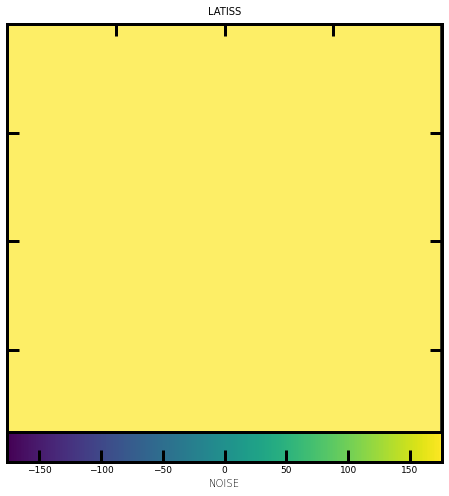

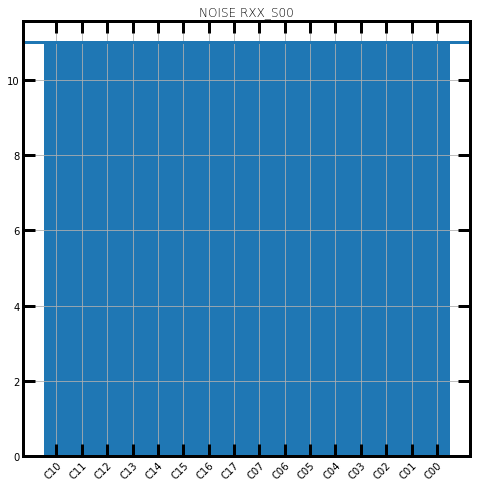

In [8]:
utils.plotFailures(runStats, camera, scaleFactor=8)

In [9]:
if useAstrowidgets:
    # Create a display object:
    import IPython.display as ipydisplay
    display = lsst.afw.display.Display(dims=(800, 600))  # size in screen pixels
    ipydisplay.display(display.embed())
else:
    fig = plt.figure(figsize=(16,16))
    display = lsst.afw.display.Display(frame=fig)

<Figure size 1152x1152 with 0 Axes>

In [10]:
for detector in camera:
    detectorId = detector.getId()
    print(f"detctorId = {detectorId}")

detctorId = 0


detectorId = 0
Detector: RXX_S00 Median: 0.997673749923706   Stdev: 0.01997537612915039


flat RXX_S00 Continue? [h, c, q, p, #] c


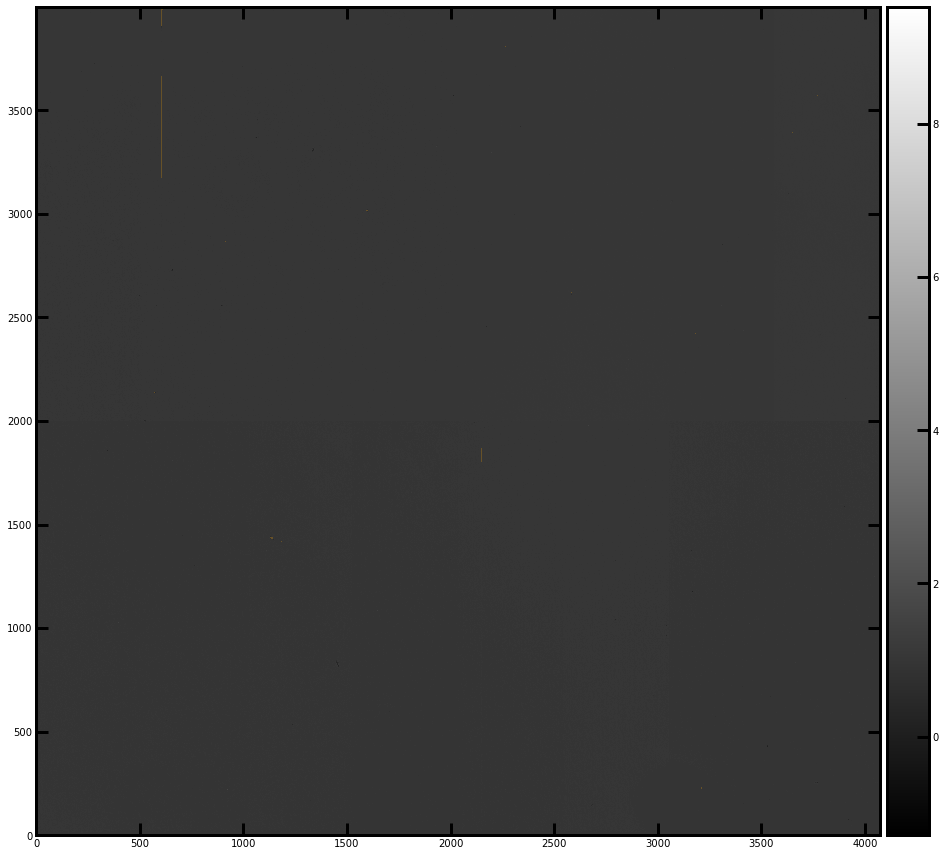

In [11]:
# View calibration images:
continueDisplay = True
for detector in camera:
    detectorId = detector.getId()
    print(f"detectorId = {detectorId}")
    calib = butler.get(calibType, instrument=cameraName, physical_filter=physical_filter, detector=detectorId)
    calibArray = calib.getImage().getArray()

    # Get simple stats
    q25, q50, q75 = np.percentile(calibArray.flatten(), [25, 50, 75])
    sigma = 0.74 * (q75 - q25)
    print(f"Detector: {detector.getName()} Median: {q50}   Stdev: {sigma}")

    display.mtv(calib)
    display._scale('linear', (q50 - 3 * sigma), (q50 + 3* sigma), "")
    display.setImageColormap('jet')

    continueDisplay, skipNumber = utils.interactiveBlock(f"{calibType} {detector.getName()}", {})
    if continueDisplay is False:
        break

-1.2898257 9.527664 0.99923915 0.99767375 0.025630722


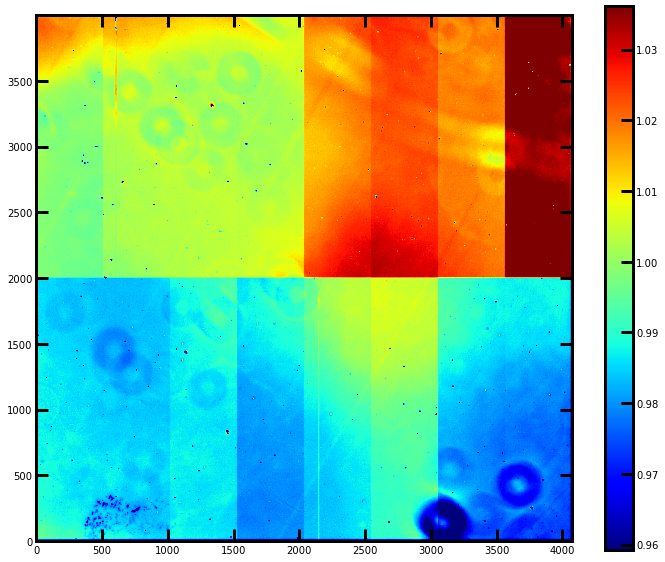

In [27]:
vmin=calib.image.array.min()
vmax=calib.image.array.max()
vmean=calib.image.array.mean()
vmed=np.median(calib.image.array)
vstd=np.std(calib.image.array)
print(vmin,vmax,vmean,vmed,vstd)
nsig=1.5
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12,10))
im=ax.imshow(calib.image.array,origin="lower",vmin=vmed-nsig*vstd,vmax=vmed+nsig*vstd,cmap="jet")
fig.colorbar(im)

In [12]:
#import lsst.afw.display as afwDisplay
#afwDisplay.setDefaultBackend('firefly')
#afw_display = afwDisplay.Display(frame=1)
#afw_display.mtv(calib)

## Show header of this Flat

In [13]:
dict(calib.getMetadata())

{'CALIB_CREATE_DATE': '2022-11-09',
 'CALIB_CREATE_TIME': '22:30:45 CET',
 'COMMENT': '---- Geometry from Camera ----',
 'ORIGIN': 'LSST DM Header Service',
 'IMGTYPE': 'FLAT',
 'BUNIT': 'adu',
 'FACILITY': 'Vera C. Rubin Observatory',
 'TELESCOP': 'LSST AuxTelescope',
 'INSTRUME': 'LATISS',
 'OBSERVER': 'LSST',
 'OBSGEO-X': 1818938.94,
 'OBSGEO-Y': -5208470.95,
 'OBSGEO-Z': -3195172.08,
 'RA': 0.0,
 'DEC': 0.0,
 'ROTCOORD': 'sky',
 'HASTART': 0.0,
 'AMSTART': 0.0,
 'HAEND': 0.0,
 'AMEND': 0.0,
 'INSTPORT': 2,
 'ATM3PORT': None,
 'TRACKSYS': 'LOCAL',
 'RADESYS': 'ICRS',
 'DOMEAZ': 273.02,
 'SHUTLOWR': 0.0,
 'SHUTUPPR': 100.0,
 'WCSAXES': 2,
 'CTYPE1': 'RA---TAN',
 'CTYPE2': 'DEC--TAN',
 'CUNIT1': 'deg',
 'CUNIT2': 'deg',
 'CRVAL1': 0.0,
 'CRVAL2': 0.0,
 'CRPIX1': 2000.0,
 'CRPIX2': 2036.0,
 'EQUINOX': 2000.0,
 'CAMCODE': 'AT',
 'CONTRLLR': 'O',
 'DAYOBS': '20220317',
 'TESTTYPE': 'FLAT',
 'EMUIMAGE': '',
 'CURINDEX': 0,
 'MAXINDEX': 1,
 'TSTAND': None,
 'OBSANNOT': '',
 'TEMP_SET': -94

In [14]:
# This block allows the residual images to be scanned for concerns.
blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    skipNumber = 0
    for exposureId, stats in runStats.items():
        for detector in camera:
            if skipNumber > 0:
                skipNumber -= 1
                continue
        
            detId = detector.getId()
            residual = butler.get('verifyFlatProc', instrument=cameraName, exposure=exposureId, detector=0)
            detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=0)
            display.mtv(residual)
            display.scale('linear', 'zscale', None)
        
            continueDisplay, skipNumber = utils.interactiveBlock(f"{exposureId} {detector.getName()}", detStats)
            if continueDisplay is False:
                break
        if continueDisplay is False:
            break

2022031700201 RXX_S00 Continue? [h, c, q, p, #] c
2022031700202 RXX_S00 Continue? [h, c, q, p, #] c
2022031700203 RXX_S00 Continue? [h, c, q, p, #] c
2022031700204 RXX_S00 Continue? [h, c, q, p, #] c
2022031700205 RXX_S00 Continue? [h, c, q, p, #] c
2022031700206 RXX_S00 Continue? [h, c, q, p, #] q


In [21]:
vmin=residual.image.array.min()
vmax=residual.image.array.max()
vmean=residual.image.array.mean()
vmed=np.median(residual.image.array)
vstd=np.std(residual.image.array)
print(vmin,vmax,vmean,vmed,vstd)

-18589.035 91209.734 18863.87 18870.82 296.74857


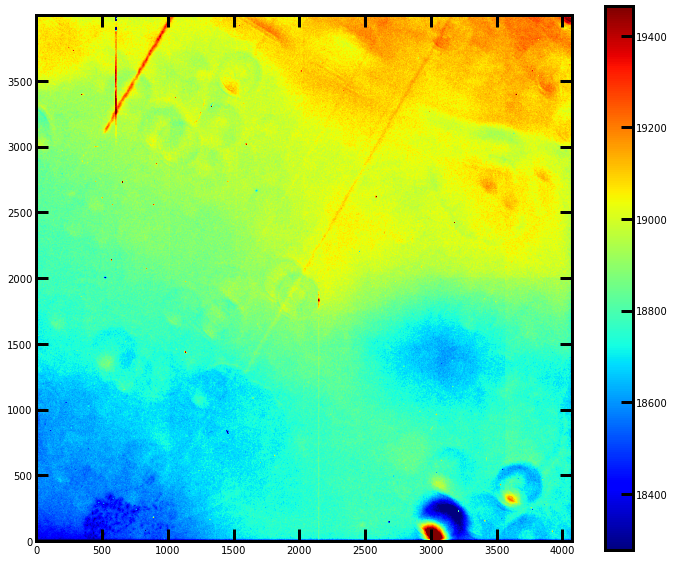

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12,10))
im=ax.imshow(residual.image.array,origin="lower",vmin=vmed-2*vstd,vmax=vmed+2*vstd,cmap="jet")
fig.colorbar(im)

In [17]:
# This cell is slow, and may be too slow to be useful during a demonstration.
# Get data for mean(expTime) plot.
ampMeans = {}
for detector in camera:
    ampMeans[detector.getName()] = {}
    for amp in detector.getAmplifiers():
        ampMeans[detector.getName()][amp.getName()] = {'ID': [], 'EXPTIME': [], 'MEAN': [], 'NOISE': []}

for exposureId, stats in runStats.items():
    print(f"{exposureId}")
    rr = butler.registry.queryDimensionRecords('exposure', 
                                               instrument=cameraName,
                                               exposure=exposureId)
    expTime = next(rr.__iter__()).exposure_time
    for detector in camera:
        detId = detector.getId()
        detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=detId)
    
        for amp in detector.getAmplifiers():
            mean = detStats['AMP'][amp.getName()]['MEAN']
            noise = detStats['AMP'][amp.getName()]['NOISE']
            ampMeans[detector.getName()][amp.getName()]['ID'].append(exposureId)
            ampMeans[detector.getName()][amp.getName()]['MEAN'].append(mean)
            ampMeans[detector.getName()][amp.getName()]['EXPTIME'].append(expTime)
            ampMeans[detector.getName()][amp.getName()]['NOISE'].append(noise)

2022031700201
2022031700202
2022031700203
2022031700204
2022031700205
2022031700206
2022031700207
2022031700208
2022031700209
2022031700210
2022031700211


detName = RXX_S00


<Figure size 576x576 with 0 Axes>

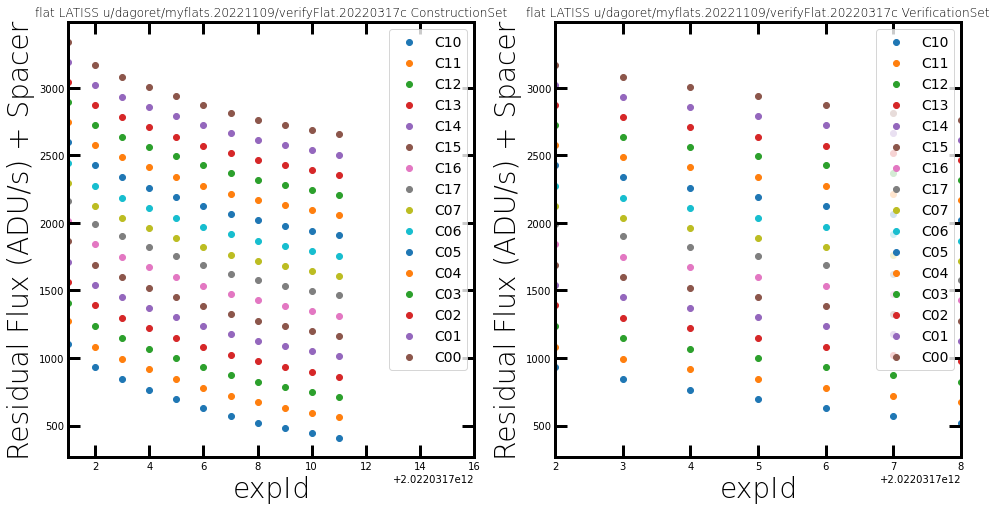

RXX_S00 Continue? [h, c, q, p, #] q


In [18]:
# Plot flux as a function of exposure id, to look for time trends.
continueDisplay = True
for detector in camera:
    detName = detector.getName()
    print(f"detName = {detName}")

    horizontalSpace = 0.0
    verticalSpace = 150
    plt.figure(figsize=(8, 8))
    fig, axes = plt.subplots(1, 2, figsize=(2 * 8, 8))
    for axis, chunk in zip(axes, [0, 1]):
        for spacer, amp in enumerate(detector.getAmplifiers()):
            axis.scatter(np.array(ampMeans[detName][amp.getName()]['ID']) + horizontalSpace * spacer,
                         np.array(ampMeans[detName][amp.getName()]['MEAN']) /
                         np.array(ampMeans[detName][amp.getName()]['EXPTIME']) + verticalSpace * spacer,
                        label=amp.getName())
        axis.set_xlabel("expId")
        axis.set_ylabel("Residual Flux (ADU/s) + Spacer")

        
        if chunk == 0:
            axis.set_xlim(EXPOSURES.min(), EXPOSURES.max()+5)
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} ConstructionSet")
        else:
            axis.set_xlim(EXPOSURES_VERIFY.min(), EXPOSURES_VERIFY.max()+5)
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} VerificationSet")
        axis.legend()
    plt.show()
    continueDisplay, skipNumber = utils.interactiveBlock(detName, {})
    if continueDisplay is False:
        break
##### END Notebook Excerpt #####

In [19]:
assert False

AssertionError: 

### Commands for a flat, part 2:
**Certification:**

    butler certify-calibrations $BUTLER_REPO \
       u/czw/bootcamp.20220630/flatGen.20220630a \
       u/czw/bootcamp.20220630/flat \
       --begin-date 2021-01-01 --end 2050-01-01 \
       flat

**Collection chaining:**

    butler collection-chain $BUTLER_REPO --mode=prepend \
        u/czw/bootcamp.20220630/calib \
        u/czw/bootcamp.20220630/flat

**Collection querying:**

    butler query-collections $BUTLER_REPO u/czw/bootcamp.20220630/calib
    

In [ ]:
!butler certify-calibrations /repo/main \
   u/czw/bootcamp.20220630/flatGen.20220630a \
   u/czw/bootcamp.20220630/flat \
   --begin-date 2021-01-01 --end-date 2050-01-01 \
   flat

In [ ]:
!butler collection-chain /repo/main --mode=prepend \
    u/czw/bootcamp.20220630/calib \
    u/czw/bootcamp.20220630/flat

In [ ]:
!butler query-collections /repo/main u/czw/bootcamp.20220630/calib